# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
* /datasets/geo_data_0.csv
* /datasets/geo_data_1.csv
* /datasets/geo_data_2.csv

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**План работы:**

1. Загрузка и подготовка данных
2. Обучение и проверка модели прогноза добычи
3. Подготовка к расчету прибыли
4. Расчет прибыли и риска убытков

## Загрузка и подготовка данных

### Импорт библиотек

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# зададим значение константы
RANDOM_STATE = 42

In [ ]:
# уберем максимальную ширину колонки для удобства просмотра
pd.set_option('display.max_colwidth', None)

### Загрузка датафреймов

Загрузим датафреймы на данных о трех регионах разведанной добычи

In [ ]:
# загрузим в датафрейм данные Региона_0
pth1 = '/datasets/geo_data_0.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'

if os.path.exists(pth1):
    data_0 = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            data_0 = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

In [ ]:
# загрузим в датафрейм данные Региона_1
pth1 = '/datasets/geo_data_1.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'

if os.path.exists(pth1):
    data_1 = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            data_1 = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

In [ ]:
# загрузим в датафрейм данные Региона_2
pth1 = '/datasets/geo_data_2.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

if os.path.exists(pth1):
    data_2 = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            data_2 = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

Все данные успешно загружены, ошибок при загрузке не возникло

### Изучение данных

Для изучения загруженных данных используем ранее написанную функцию, которая:
 - выводит общую информацию о датафрейме методом info()
 - выводит верхние 5, случайные 10 и нижние 5 строк из датафрейма, для визуального осмотра данных в датафрейме
 - выводит статистические показатели числовых значений датафрейма для опрелеления аномалий в числовых данных
 - выводит информацию о строках дубликатах
 - выводит информацию о количество пропусков данных в датафрейме
 - выводит информацию о доле пропусков в датафрейме для определения их влияния на данные
 - выводит информацию об уникальных значениях строчных данных для определения неявных дубликатов
 - выводит информацию о количестве уникальных значений, чтобы сопоставить их с количеством вхождений

In [ ]:
# используем ранее написанную функцию для изучения основной информации о датасетах
def data_info(data):
    display(data.info()) # вывод информации о датафрейме
    print('=' * 20)
    display(data.head()) # вывод верхнийх 5 строк датафрейма
    display(data.sample(10)) # вывод случайных 10 строк датафрейма
    display(data.tail()) # вывод нижних 5 строк датафрейма
    display(data.describe().T) # вывод статистических показателей числовых значений датафрейма
    print('Количество явных дубликатов: ', data.duplicated().sum()) # определение количества явных дубликатов строк
    print('Строки дубликаты:\n', data[data.duplicated()]) # вывод строк дубликатов, для их проверки
    print('=' * 20)
    print('Количество пропусков:\n', data.isna().sum()) # Вывод количества пропусков в датафрейме
    print('Доля пропусков в датафрейме:') # вывод информации о доле пропусков в датафрейме
    col = data.columns.tolist() # введем переменную со списком названий столбцов
    # циклом выведем долю пропусков в каждом столбце
    for a in col:
        print(f'В столбце {a} доля пропусков: {(data[a].isnull().sum() / len(data[a])*100).round(3)}%')
    print('=' * 20)
    print('Список уникальных значений в датафрейме:')
    # выведем список уникальных строковых значений для определения неявных дубликатов
    for b in data.select_dtypes('object').columns: # задаем поиск только по столбцам со строковыми данными
        print('Уникальные значения:')
        print(f'{b}: {data[b].unique()}')
        print('Количество уникальных значений:')
        print(f'{b}: {data[b].nunique()}')


Здесь и далее, для цикличной автоматизации обработки всех датафреймов, будем использовать Даталист - переменную со списком всех датафремов. Для отображения названия региона введем счетчик 'r'

In [ ]:
data_list = [data_0, data_1, data_2]

In [ ]:
r=0 # стартовое значение счетчика
for d in data_list:
    print(f'Информация о данных Региона_{r}:\n')
    print (data_info(d), '\n<', '='*60, '>', '\n\n\n')
    r+=1 # увеличиваем счетчик на 1

Информация о данных Региона_0:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
11816,J4xfO,-0.813825,0.560490,4.493776,84.469578
13033,3iqk1,1.915847,-0.212233,5.645117,182.153006
61203,FM07c,1.977927,0.175789,6.797606,155.450999
49706,HQZ3w,0.113576,-0.102631,6.043081,125.255521
60156,xfiXb,-0.727356,0.889902,2.170907,65.828579
34562,lJ07l,-0.621147,0.895432,1.929271,123.385909
25617,MqgtB,0.908295,0.426422,2.302585,43.772810
15911,fIFAK,1.371753,-0.648342,4.613735,122.828626
61389,sI38E,1.334878,-0.472219,6.072126,165.054310
17661,JD6ZX,0.448576,-0.365949,1.291017,48.981467


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце f0 доля пропусков: 0.0%
В столбце f1 доля пропусков: 0.0%
В столбце f2 доля пропусков: 0.0%
В столбце product доля пропусков: 0.0%
Список уникальных значений в датафрейме:
Уникальные значения:
id: ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
Количество уникальных значений:
id: 99990
None 
< ============================================================ > 



Информация о данных Региона_1:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2   

None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
53357,7kZSL,-14.760858,0.347088,0.009818,3.179103
25221,pl90W,-4.547133,-0.578131,5.005954,137.945408
8000,sD7xH,-7.966218,-1.808901,1.993600,57.085625
14573,yNJEf,-6.723852,-0.342720,-0.000242,3.179103
59211,HGroF,-5.340052,-6.379315,5.011864,137.945408
94475,ZoXhE,8.896922,-6.739211,0.003540,0.000000
96375,EC6q7,-9.482889,-15.635562,0.996695,30.132364
66958,Nr0lF,9.769287,-3.558103,4.993970,134.766305
64897,Wi7Vr,-0.650846,-5.269188,4.995419,134.766305
47467,XEXS0,7.070326,-9.079748,4.000351,107.813044


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце f0 доля пропусков: 0.0%
В столбце f1 доля пропусков: 0.0%
В столбце f2 доля пропусков: 0.0%
В столбце product доля пропусков: 0.0%
Список уникальных значений в датафрейме:
Уникальные значения:
id: ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
Количество уникальных значений:
id: 99996
None 
< ============================================================ > 



Информация о данных Региона_2:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2   

None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,id,f0,f1,f2,product
54641,OzQ4A,1.729752,0.208902,3.005155,47.235412
66644,jFLG9,-0.287974,-0.476378,4.878033,134.337046
82230,Hvolv,-0.332026,1.515604,5.417583,27.570897
25491,8vYqw,2.086787,-0.759664,-0.269585,54.332899
64470,CpMsw,1.735138,0.829249,3.571971,146.123535
4610,bP5Sy,-0.358940,-2.784734,4.605274,114.079422
64850,FHueK,1.409870,-1.959282,0.610206,81.765570
44644,mgUgP,1.780496,-1.566730,3.995380,135.991136
78265,0lpdE,-1.654953,-0.002161,3.846961,32.506053
96176,tVVml,-0.013361,-0.011213,2.583339,55.368600


,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце f0 доля пропусков: 0.0%
В столбце f1 доля пропусков: 0.0%
В столбце f2 доля пропусков: 0.0%
В столбце product доля пропусков: 0.0%
Список уникальных значений в датафрейме:
Уникальные значения:
id: ['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']
Количество уникальных значений:
id: 99996
None 
< ============================================================ > 





В процессе исследования установлено, что в столбце id имеются дубликаты идентификаторов скважин, изучим эти строки

In [ ]:
display(data_0[data_0['id'].duplicated()],
        data_1[data_1['id'].duplicated()],
        data_2[data_2['id'].duplicated()])

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Просмотрим детально все вхождения строк дубликатов

In [ ]:
for d in data_list:
    for p in d[d['id'].duplicated()]['id'].unique():
        display(d[d['id'] == p], '\n')

         id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695 

          id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798 

          id        f0        f1        f2    product
3389   A5aEY -0.039949  0.156872  0.209861  89.249364
51970  A5aEY -0.180335  0.935548 -2.094773  33.020205 

          id        f0        f1        f2    product
1949   QcMuo  0.506563 -0.323775 -2.215583  75.496502
63593  QcMuo  0.635635 -0.473422  0.862670  64.578675 

          id        f0        f1        f2     product
64022  74z30  0.741456  0.459229  5.153109  140.771492
66136  74z30  1.084962 -0.312358  6.990771  127.643327 

          id        f0        f1        f2     product
42529  AGS9W  1.454747 -0.479651  0.683380  126.370504
69163  AGS9W -0.933795  0.116194 -3.655896   19.230453 

       

Видим, что у одних и тех же скважин разные признаки точек и разные показатели продуктивности скважины. Возможно в датафреймы попали замеры с разным временным промежутком, либо при загрузке id одной скважины переписалось на другую. Мы не можем установить точные причины задвоения id, но при получении результата, задвоенные id будут мешать идентификации наиболее продуктивных скважин. Поэтому к каждому дубликату добавим дополнительный символ, показывающий, что это дубликат. Для переименования напишем отдельную функцию

In [ ]:
def rename_duplicates(data, column_name):
    # Создаем словарь для подсчета дубликатов
    counts = {}

    # Создаем новый список для обновленных значений
    new_values = []

    # Проходим по каждому значению в столбце
    for value in data[column_name]:
        # Если значение уже встречалось, увеличиваем счетчик
        if value in counts:
            counts[value] += 1
            # Формируем новое уникальное значение
            new_value = f'{value}_{counts[value]}'
        else:
            # Если значение встречается впервые, инициализируем счетчик
            counts[value] = 1
            new_value = value

        # Добавляем новое значение в список
        new_values.append(new_value)

    # Обновляем столбец в датафрейме
    data[column_name] = new_values
    return data

In [ ]:
# запускаем цикл переименования по даталисту
r=0 # обнуляем счетчик
for d in data_list:
    rename_duplicates(d, 'id')

    # Выведем на экран проверку уникальных значений для каждого датафрейма
    # контрольное число 100000
    print(f'Количество уникальных значений id скважин Региона_{r}: {d["id"].nunique()}')
    r+=1

Количество уникальных значений id скважин Региона_0: 100000
Количество уникальных значений id скважин Региона_1: 100000
Количество уникальных значений id скважин Региона_2: 100000


### Статистический анализ данных

In [ ]:
r=0
for d in data_list:
    print (f'Статистические данные признаков Региона_{r}:')
    display(d.describe().T)
    print('_'*80, '\n\n')
    r+=1

Статистические данные признаков Региона_0:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


________________________________________________________________________________ 


Статистические данные признаков Региона_1:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


________________________________________________________________________________ 


Статистические данные признаков Региона_2:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


________________________________________________________________________________ 




### Графический анализ данных

Для отображения корректных подписей к графикам введем словарь подписей - subs и используем ранее написанную функцию для построения графиков по количественным данным

In [ ]:
# запишем переменную со словарем имен колонок и их подписям в графиках
subs = {'f0': 'значению признака f0',
        'f1': 'значению признака f1',
        'f2': 'значению признака f2',
        'product': 'продуктивности скважины'
       }

In [ ]:
# функция построения графиков для количественных данных
def quant_plot(graf_data, subtitle, xlabel, ylabel):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    fig.suptitle(subtitle)

    # гистограмма для отображения распределения
    plt.subplot (2, 2, 1)
    sns.histplot(graf_data, kde=True, bins=50)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # диаграмма размаха
    plt.subplot (2, 2, 2)
    sns.boxplot(x=graf_data)
    plt.xlabel(xlabel)

    plt.show()

__________________________________________________________________________________________


Распределение признаков Региона_0:


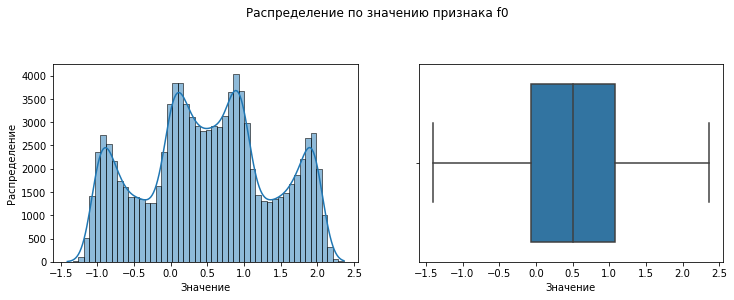

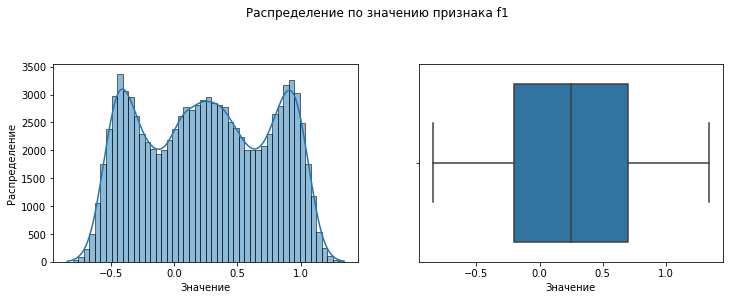

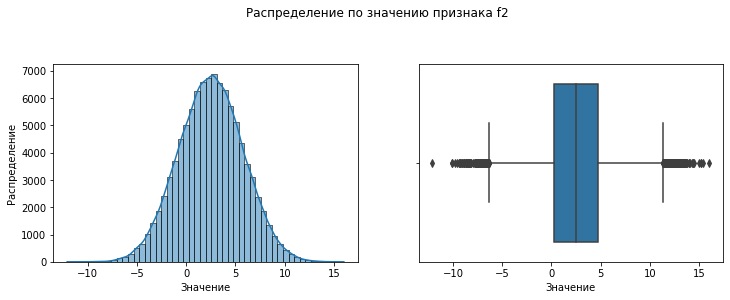

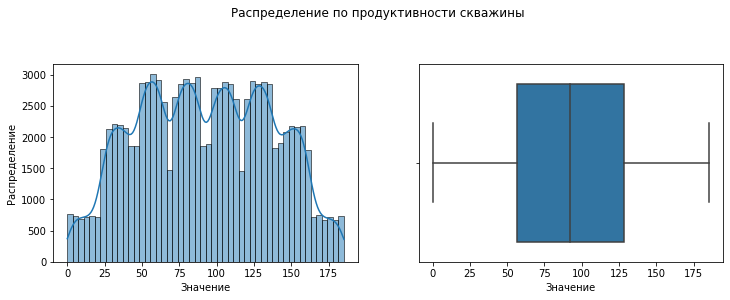

__________________________________________________________________________________________


Распределение признаков Региона_1:


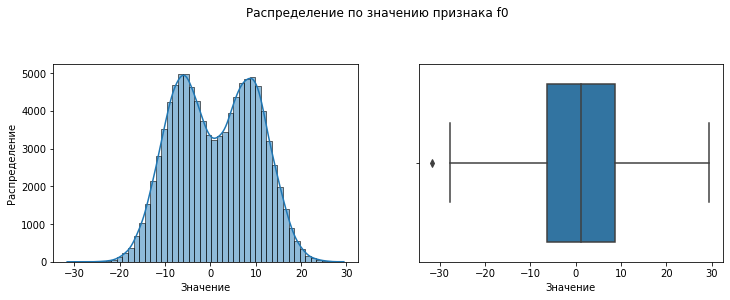

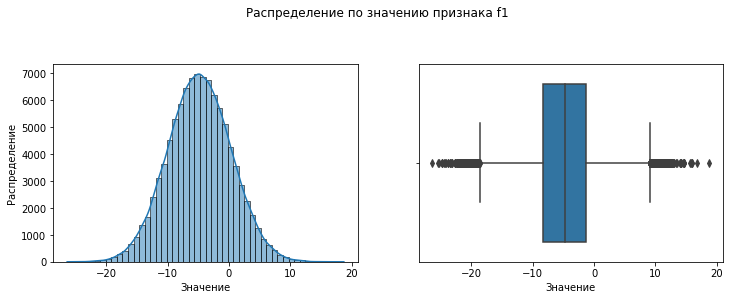

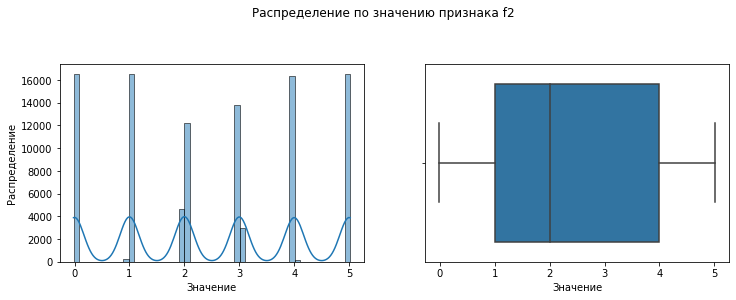

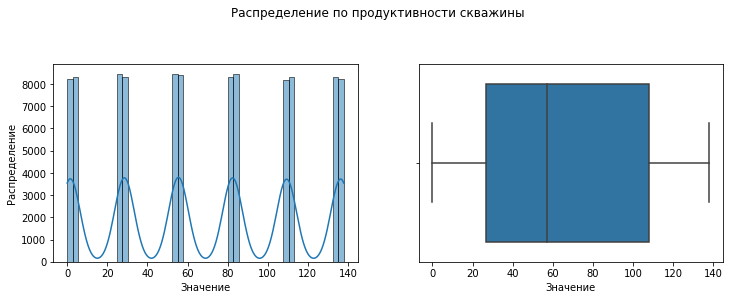

__________________________________________________________________________________________


Распределение признаков Региона_2:


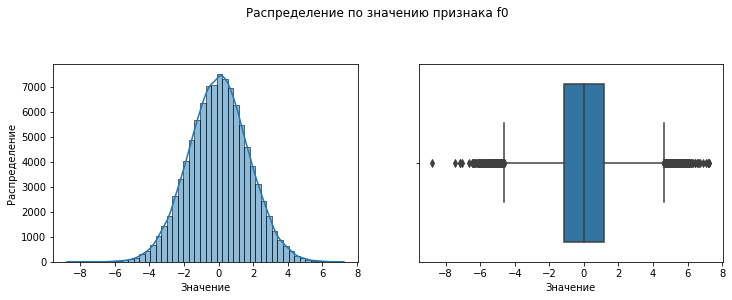

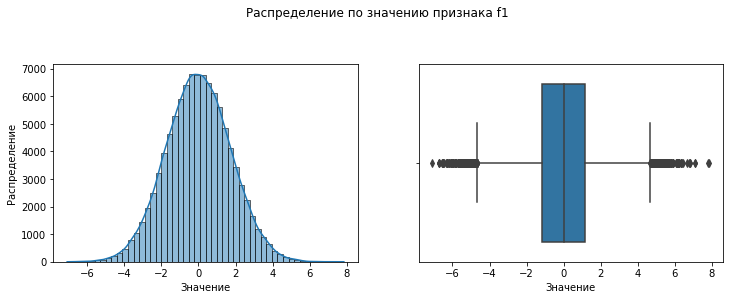

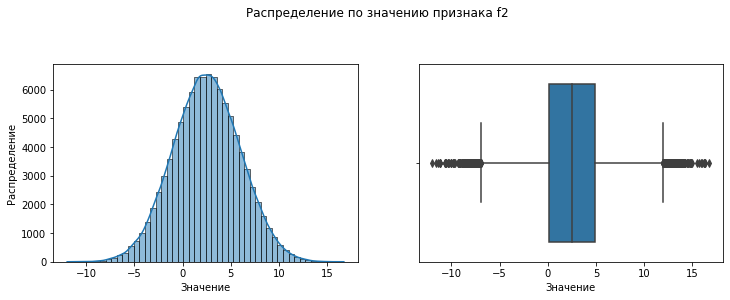

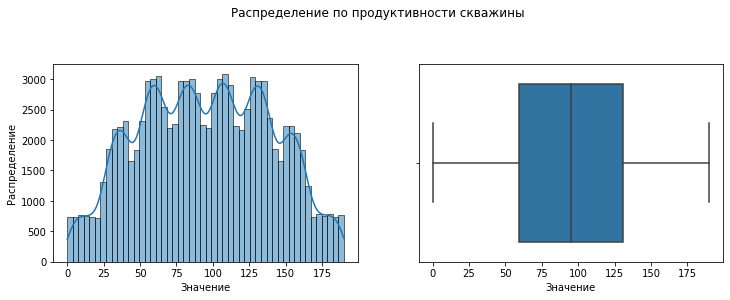

In [ ]:
r=0
for d in data_list:
    print('_'*90)
    print (f'\n\nРаспределение признаков Региона_{r}:')
    r+=1
    for p in d.drop(['id'],axis=1):
        quant_plot(d[p], f'Распределение по {subs.get(p)}', 'Значение', 'Распределение')

### Корреляционный анализ данных

Для оценки взаимной корреляции признаков построим корреляционные матрицы для всех датафреймов. Так как все призрнаки у нас однородные и числовые, то вычислять phik не будем и построим матрицу на обычной корреляции признаков

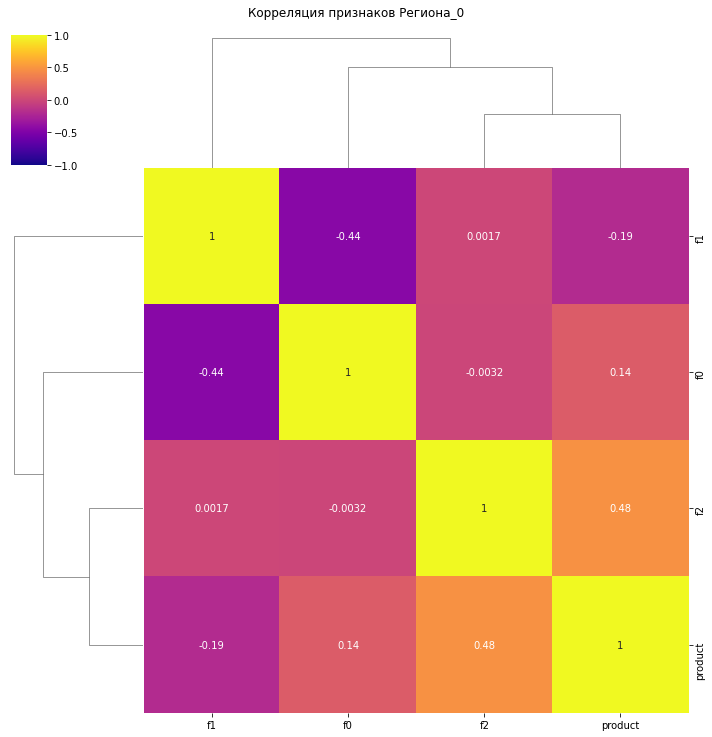

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


________________________________________________________________________________


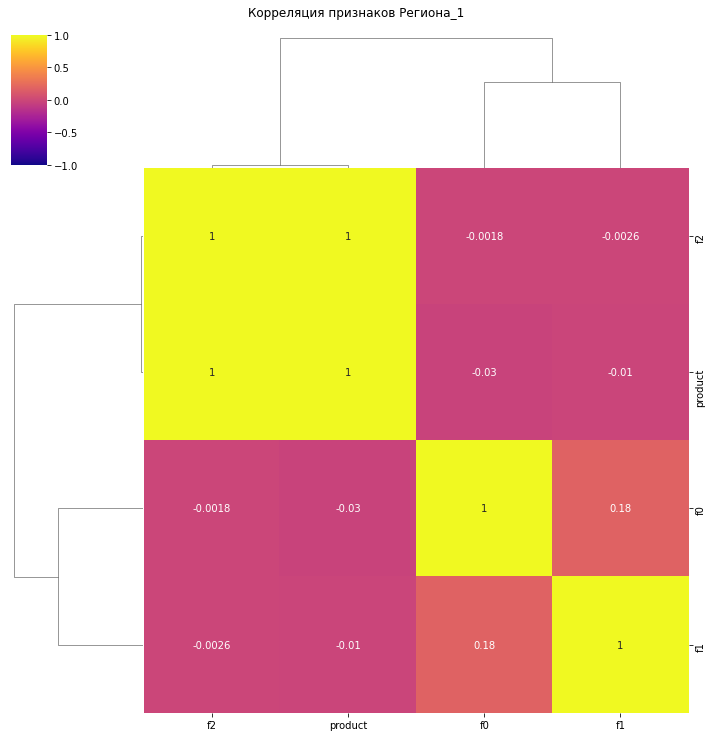

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


________________________________________________________________________________


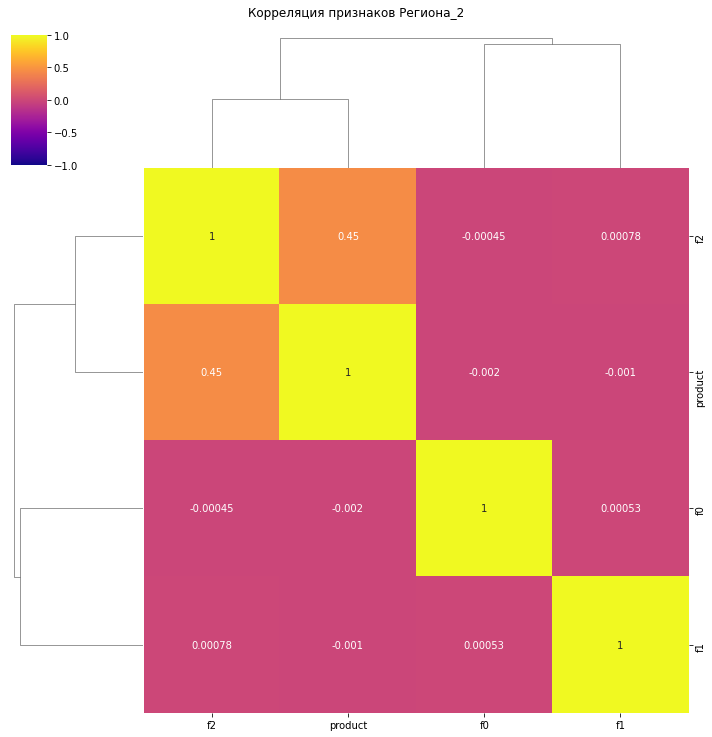

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


________________________________________________________________________________


In [ ]:
r=0
for d in data_list:
    data_corr = d.drop(['id'],axis=1).corr()
    ax = sns.clustermap(
        data_corr,
        annot=True,
        vmin=-1,
        vmax=1,
        center=0,
        cmap='plasma')
    ax.fig.suptitle(f'Корреляция признаков Региона_{r}', y=1.02)
    plt.show()
    display(data_corr)
    print('_'*80)
    r+=1

### Выводы по блоку

В результате исследования данных установлено:
 - каждый датафрейм изначально состоял из 100 000 строк и 5 колонок. Все колонки, кроме id числовые. Числовые данные - дробные, есть и отрицательные и положительные значения в признаках трех точек, значения продуктивности положительные (от 0 и выше)
 - явных дубликатов строк не выявлено
 - пропусков данных не выявлено
 - явных выбросов в данных продуктивности не выявлено. Возможность выбросов в признаках трех точек не известная, из-за отсутствия информации о значении указанных признаков
 - есть дубликаты в указании id, но с разными числовыми признаками, эти дубликаты переименованы для правильной идентификации скважин
 - данные в датафреймах явно синтетические (это и так указано в условиях задачи), распределение входных признаков разнообразное.
 - распределение продуктивности скважин разное, без ярких выбросов.
 - средняя продуктивность скважин в Регионе_0 - 92.5 медианная 91.85, средняя продуктивность скважин в Регионе_1 - 68.8 медианная - 57.08, средняя продуктивность свкважин в Регионе_2 - 95, медианная 94.5.
 - при построении матрицы корреляции видим, что в разных регионах разная корреляция между входными признаками и целевым, при этом в регионе_1 между признаком f2 и целевым корреляция максимально близка к 1. Однако по условиям задачи мы не можем исключить этот признак из обучения из-за риска мультиколлинеарности, так как все входные признаки являются существенными.

## Обучение и проверка модели

Поскольку у нас необходимо обучить на каждом датафрейме модель с одинаковыми параметрами и одной моделью линейной регрессии, удобнее всего процесс обучения упаковать в функцию.
В выборках у нас все данные числовые, дробные, дискретных величин нет, признаки однотипные.

### Подготовка функции для обучения

Для записи результатов обучения и вычислений в каждом регионе, введем переменную датафрейм - results

In [ ]:
# создадим датафрейм для записи результатов работы моделей
results = pd.DataFrame(index=range(3), columns=['region', 'true', 'predict', 'rmse', 'mean'])
results['region'] = ['Регион_0', 'Регион_1', 'Регион_2']

In [ ]:
# запишем в качестве глобальной, модель линейной регрессии
model_lr = LinearRegression()

In [ ]:
# запишем функцию, которая по шагам будет готовить данные и обучать модели
# параметр data - для датафрейма с которым будем работать, параметр num для номера региона
def lin_reg (data, num):

    # Шаг 1: Разделим входные и целевой признаки
    X = data.drop(['id', 'product'], axis=1).drop_duplicates() # входные признаки
    y = data['product'] # целевой признак

    # Шаг 2: Разбьём данные на обучающую и валидационную выборки в соотношении 75:25
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=RANDOM_STATE
    )
    results.at[num, 'true'] = y_valid

    # Шаг 3: Обучение модели
    global model_lr
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    results.at[num, 'predict'] = model_lr.predict(X_valid)

    # Шаг 4. Оценка качества модели и среднее значение
    results.at[num, 'rmse'] = mean_squared_error(y_valid, results['predict'].iloc[num], squared=False)
    results.at[num, 'mean'] = results.loc[num, 'predict'].mean()

### Обучение и запись результатов

Поскольку обучение будем проводить в цикле, для простоты дополнительно подготовим датафреймы для каждого региона для дублирования результатов оценок. Они нам понадобятся для подготовки реестра продуктивных скважин

In [ ]:
data_0_pred = pd.DataFrame()
data_1_pred = pd.DataFrame()
data_2_pred = pd.DataFrame()

In [ ]:
r=0 # счтетчик для определения индекса строки
for d in data_list:
    lin_reg(d, r)
    loc_rmse = results.loc[r, 'rmse']
    loc_mean = results.loc[r, 'mean']
    reg = results.loc[r, 'region']
    if r==0:
        data_0_pred['true'] = results.loc[r, 'true']
        data_0_pred['pred'] = results.loc[r, 'predict']
    elif r==1:
        data_1_pred['true'] = results.loc[r, 'true']
        data_1_pred['pred'] = results.loc[r, 'predict']
    elif r==2:
        data_2_pred['true'] = results.loc[r, 'true']
        data_2_pred['pred'] = results.loc[r, 'predict']
    print(f'Регион: {reg}\n',
          f'Прогнозируемый средний запас сырья: {loc_mean.round(2)} единиц\n',
          f'rmse: {loc_rmse.round(2)}\n\n')
    r+=1

Регион: Регион_0
 Прогнозируемый средний запас сырья: 92.4 единиц
 rmse: 37.76


Регион: Регион_1
 Прогнозируемый средний запас сырья: 68.71 единиц
 rmse: 0.89


Регион: Регион_2
 Прогнозируемый средний запас сырья: 94.77 единиц
 rmse: 40.15




### Выводы по блоку

В процессе подготовки и обучения, по условиям задачи, мы подготовили функцию для обучения по модели линейной регрессии, все результаты и оценки записали в основной датафрейм с результатами.

Самая лучшая оценка RMSE, максимально близкая к 0, это оценка Региона_1, хотя у этого региона и самый низкий прогнозируемый средний запас сырья. Однако мы понимаем, что высокий средний запас может быть вызван сильными выбросами.

## Подготовка к расчёту прибыли

Перед расчетом прибыли для лучших скважин, обогатим наши результаты предсказаний id  сважин, чтобы мы могли определять, какие именно скважины вошли в топ по продуктивности. Этого нет в задаче работы, однако, на практике, мало определить лучшие результаты продуктивности, необходимо еще и составить реестр скважин, в которых будет вестись разработка

In [ ]:
# Подготовим датафреймы с реестром id
data_0_id = data_0['id']
data_1_id = data_1['id']
data_2_id = data_2['id']

In [ ]:
# объединим датафреймы с результатами предсказаний и с id
data_0_pred = pd.merge(data_0_pred, data_0_id, left_index=True, right_index=True)
data_1_pred = pd.merge(data_1_pred, data_1_id, left_index=True, right_index=True)
data_2_pred = pd.merge(data_2_pred, data_2_id, left_index=True, right_index=True)

Запишем константы для расчета прибыли:
- количество исследуемых точек -  500 точек
- выборка для разработки - 200 из 500 точек
- бюджет на разработку скважин в регионе — 10 млрд рублей
- доход с каждой единицы продукта - 450 тыс. рублей
- после оценки рисков оставляются лишь те регионы, в которых вероятность убытков меньше 2.5%.


### Определение значений для расчета прибыли

In [ ]:
# Все ключевые значения для расчётов сохраним в отдельных переменных.
TOTAL_POINTS = 500 # количество исследуемых точек
SELECT_POINTS = 200 # количество выбранных точек
REG_BUDGET = 10**10 # бюджет на разработку скважин в регионе
PROD_PROFIT = 450 * 10**3 # доход с единицы продукта
PROB_LOSS = 0.025 # порог убытков

# бюджет на разработку каждой из выбранных точек
BUDGET_POINTS = REG_BUDGET / SELECT_POINTS

### Расчет порога безубыточности

Минимальный объем добычи для безубыточной разработки расчитывается по формуле:

**Бюджет на разработку одной точки** / **доход с единицы продукта** = **количество единиц добычи для порога самоокупаемости**

Все что выше этого порога и будет безубыточной добычей

In [ ]:
# Рассчитайем достаточный объём сырья для безубыточной разработки новой скважины.
MIN_PROD = BUDGET_POINTS / PROD_PROFIT
print(f'Порог безубыточной добычи равен {int(MIN_PROD)} единиц или {round(MIN_PROD * 1000, 2)} баррелей')

Порог безубыточной добычи равен 111 единиц или 111111.11 баррелей


### Сравнение показателей скважин с порогом безубыточности

Результаты сравнения снова выведем на экран циклом перебора по даталисту

In [ ]:
r=0
for d in data_list:
    prod = d['product']
    mean = prod.mean()
    pred_mean = results.loc[r, 'mean']
    reg = results.loc[r, 'region']
    r+=1
    print (f'{reg}:')
    print (f'Cредний запас сырья {mean.round(2)} единиц')
    print (f'Cредний прогнозируемый запас сырья {pred_mean.round(2)} единиц')

    if mean > MIN_PROD:
        print (f'Средний запас сырья региона больше порога безубыточности на {(mean - MIN_PROD).round(2)} единиц')
    else:
        print (f'Средний запас сырья региона меньше порога безубыточности на {(MIN_PROD - mean).round(2)} единиц\n')

Регион_0:
Cредний запас сырья 92.5 единиц
Cредний прогнозируемый запас сырья 92.4 единиц
Средний запас сырья региона меньше порога безубыточности на 18.61 единиц

Регион_1:
Cредний запас сырья 68.83 единиц
Cредний прогнозируемый запас сырья 68.71 единиц
Средний запас сырья региона меньше порога безубыточности на 42.29 единиц

Регион_2:
Cредний запас сырья 95.0 единиц
Cредний прогнозируемый запас сырья 94.77 единиц
Средний запас сырья региона меньше порога безубыточности на 16.11 единиц



Видим, что на текущий момент, ориентируясь на средние показатели, средняя добыча региона ниже порога безубыточности, но это не значит, что каждый регион в целом безубыточный, так как нам необходимо отоборать 200 лучших скважин. Определим долю и количество скважин в кажом регионе с запасом сырья выше порога безубыточности.

Для наглядности отображение долей проведем с помощью графиков и выведем количество скважин в каждом регионе выше и ниже порога безубыточности

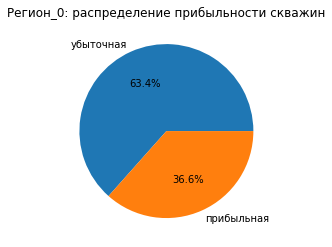

Общее количество скважин выше порога прибыльности: 36583
Общее количество скважин ниже или равным порогу прибыльности: 63417
________________________________________________________________________________


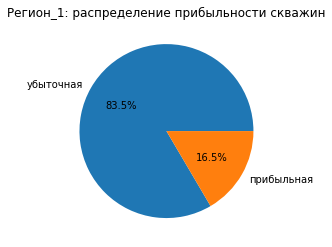

Общее количество скважин выше порога прибыльности: 16537
Общее количество скважин ниже или равным порогу прибыльности: 83463
________________________________________________________________________________


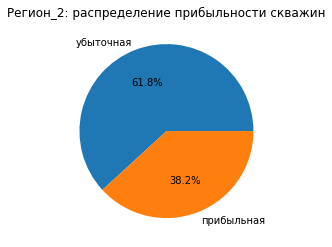

Общее количество скважин выше порога прибыльности: 38178
Общее количество скважин ниже или равным порогу прибыльности: 61822
________________________________________________________________________________


In [ ]:
r=0
for d in data_list:
    # запишем все результаты продуктивности
    data_cat = d['product']
    # разделим все скважины по порогу безубыточности
    data_cat = data_cat.apply(lambda x: 'убыточная' if x <= MIN_PROD else 'прибыльная')
    reg = results.loc[r, 'region']
    r+=1

    # построим круговую диаграмму по долям
    plt.pie(
        data_cat.value_counts(),
        labels=data_cat.unique(),
        autopct='%1.1f%%')
    plt.title((f'{reg}: распределение прибыльности скважин'))
    plt.grid()
    plt.show()
    high = d[d['product'] > MIN_PROD]['product'].count()
    low = d[d['product'] <= MIN_PROD]['product'].count()
    # выведем количество скважин каждой категории
    print(f'Общее количество скважин выше порога прибыльности: {high}')
    print(f'Общее количество скважин ниже или равным порогу прибыльности: {low}')
    print('_'*80)

Видим, что не смотря на то, что средний объем запасов ниже уровня безубыточности, в каждом регионе достаточно скважин для выборки лучших 200 по добыче с показателями выше порога безубыточности

### Выводы по блоку

 В процессе подготовки к расчету прибыли было сделано следующее:
  - в константы записаны основные вводные показатели для расчетов прибыли
  - определен порог безубыточности
  - проведено сравнение средней продуктивности каждого региона и порога безубыточности. Определено, что в каждом регионе средняя продуктивность ниже порога безубыточности и определено отклонение от порога безубыточности для каждого региона.
  - для корректности дальнейших расчетов, проанализировано какая доля скважин имеет продуктивность ниже и выше порога безубыточности и какое их количество относится к каждой из этих категорий. Определено, что в каждом регионе достаточно скважин выше порога безубыточности чтобы отобрать 200 лучших по продуктивности

## Расчёт прибыли и рисков

Для рачета прибыли, нам необходимо:
 - подготовить функцию расчета прибыли
 - посчитать риски и прибыль для каждого региона
 - определить в каких регионах будем вести добычу, исходя из риска убытков

### Подготовка функции

Для функции расчетов прибыли датафреймы с результатами предсказаний занесем в даталист для работы цикла

In [ ]:
pred_list = [data_0_pred, data_1_pred, data_2_pred]

Напишем функцию для расчета прибыли

In [ ]:
# Функция расчета прибыли
def profit(data):
    # запишем переменную с данными 200 лучших скважин в каждом датафрейме
    data_top = data.sort_values(
        by='pred',
        ascending=False
    ).head(SELECT_POINTS)
    # выведем результат расчета прибыли по 200 лучшим скважинам
    return (data_top['prod'].sum() * PROD_PROFIT) - REG_BUDGET

Следующим шагом напишем функцию для расчета доходов и риска убытков

In [ ]:
# Функция расчета доходов и убытков
def profit_loss(data):

    # сборка локального датафрейма
    data_loc = pd.DataFrame({
        'prod':data['true'].values,
        'pred':data['pred']
    })

    # значение для random_state
    state = np.random.RandomState(42)

    # массив доходности после применения техники bootstrep
    boot_values = []

    # цикл бутстрепа по 1000 выборкам
    for i in range(0, 1000, 1):
        data_sample = data_loc.sample(
            n=TOTAL_POINTS,
            replace=True,
            random_state=state
        )

        boot_values.append(profit(data_sample))
    boot_values = pd.Series(boot_values)

    # средний доход
    mean_profit = int(boot_values.mean())

    # нижний квантиль 2.5% от 95% доверительного интервала
    lower = int(boot_values.quantile(.025))

    # верхний квантиль 97.5% от 95% доверительного интервала
    upper = int(boot_values.quantile(.975))

    # вероятность убытка
    probability_of_loss = (boot_values.values < 0).mean()
    reg = results.loc[r, 'region']

    # вывод результатов
    print (f'{reg}:')
    print(f'Средний доход - {round(mean_profit/10**6, 2)} млн. руб')
    print(f'95% доверительный интервал доходности находится в пределах от {round(lower/10**6, 2)} до {round(upper/10**6, 2)} млн.руб.')
    print(f'Вероятность убытка -  {probability_of_loss*100}%\n')

    # запись результатов в результат работы функции
    return mean_profit, probability_of_loss

### Расчет рисков и средней прибыли

После подготовки функций, проведем расчет средней прибыли и риска убытков

In [ ]:
r=0
# в датафрейме с результатами ведем колонку с пустыми значниями для реестра лучших скважин
results['top'] = pd.NA

# запустим цикл перебора датафреймов с оценками и id
for dp in pred_list:

    # запишем в results сумму дохода региона
    results.at[r, 'reg_profit'] = dp['true'].sum() * PROD_PROFIT - REG_BUDGET

    # запишем в results среднюю прибыль и вероятность убытков
    # выведем результат работы функции
    results.at[r,'mean_profit'], results.at[r, 'prob_loss'] = profit_loss(dp)

    # запишем в results реестр лучших скважин
    top = dp.sort_values(
        by='pred',
        ascending=False
    ).head(SELECT_POINTS)['id'].to_list()
    results.at[r, 'top'] = top
    r+=1

Регион_0:
Средний доход - 399.58 млн. руб
95% доверительный интервал доходности находится в пределах от -110.47 до 897.46 млн.руб.
Вероятность убытка -  6.0%

Регион_1:
Средний доход - 452.05 млн. руб
95% доверительный интервал доходности находится в пределах от 61.68 до 845.34 млн.руб.
Вероятность убытка -  1.5%

Регион_2:
Средний доход - 375.01 млн. руб
95% доверительный интервал доходности находится в пределах от -144.77 до 888.39 млн.руб.
Вероятность убытка -  8.0%



### Рекомендация по выбору региона разработки

На основании ранее сделаных расчетов автоматизируем вывод рекомендаций по выбору региона для разработки

In [ ]:
# Рекомендация по лучшим регионам для разработки
reg_rec = results[results['prob_loss'] < PROB_LOSS]
reg_rec = reg_rec[['region', 'top', 'reg_profit', 'mean_profit', 'prob_loss']]
reg_rec = reg_rec.sort_values(by='prob_loss', ascending=False)

print('Для разработки рекомендуются следующие регионы:\n(в порядке увеличения риска убытков)\n')
for i in reg_rec.index:
    print(reg_rec.loc[i,'region'])
    print(f'Риск убытков региона: {reg_rec.loc[i, "prob_loss"]*100}%')
    print(f'Допустимый риск убытков: {PROB_LOSS*100}%')
    print(f'Общая прибыль региона: {round(reg_rec.loc[i,"reg_profit"]/10**9, 2)} млрд.руб.')
    print(f'Средняя прибыль скважин в регионе: {round(reg_rec.loc[i,"mean_profit"]/10**6, 2)} млн.руб.')
    print(f'Реестр скважин для разработки:\n{reg_rec.loc[i,"top"]}\n\n')

Для разработки рекомендуются следующие регионы:
(в порядке увеличения риска убытков)

Регион_1
Риск убытков региона: 1.5%
Допустимый риск убытков: 2.5%
Общая прибыль региона: 763.16 млрд.руб.
Средняя прибыль скважин в регионе: 452.05 млн.руб.
Реестр скважин для разработки:
['kpPCd', 'vd9ik', 'a8qSM', '1m8tG', '55xmk', 'ejqnA', 'qXVl2', 'LUG2F', '44PZ0', 'xDAeX', 'cWthM', 'jkSkz', 'JQEVL', 'j7Pil', 'Lo4Pm', 'OdFn6', 'sY6bY', 'vZ23x', 'zQohB', 'IG3a3', 'Ibu1s', 'UTQEM', 'ypzFJ', 'HLkNz', 'meDpG', 'X7qdm', 'EfOwG', 'mdBcB', 'bvPaR', 'JcSJg', 'uPl1m', 'di4FO', 'VSPqS', '1VzEl', 'vD2II', '9nH31', 'jLgiA', 'RxIYv', 'OjgQB', 'G8ymu', 'mkoWM', '3ZStb', '2ZTCk', 'gkYQL', 'j04js', 'ENwf1', 'N2baR', '7Sb6q', 'VolNx', 'p1sq8', 'NKDRd', 'pMXF2', 'b9U5X', 'Ihs0y', 'ssXc4', 'DPp8p', 'ky0MD', '4SUPs', 'FwOcV', 'qaBxR', 'rJvMK', 'c8CXP', 'YEVo2', 'QyVAf', '36LnE', 'KKgWy', 'MmTCb', '1LY3N', '99qlB', 'O0wF4', 'UJVbJ', 'br5JE', 'J6LSI', 'hYMKt', 'SeeW4', 'D0pE3', 'Ia4Rn', 'zkvT2', 'Um2d2', '8fMRT', 'kfV3

### Выводы по блоку

В процессе расчета прибыли и рисков:
 - подготовлены необходимы для расчета прибыли и риска убытков функции
 - на основании этих функций проведена оценка каждого региона
 - на основании этих оценок автоматизирован выбор регионов для разработки. По факту из трех регионов только один регион соответствует требованими риска убытков менее 2,5% - Регион_1.
 - в процессе оценки каждого региона и после выбора региона выведен реестр из 200 скважин с максимальной продуктивностью для разработки

## Общий вывод

По условиям задачи необходимо было для гипотетической добывающей компании «ГлавРосГосНефть» подготовить автоматизированное решение для выбора мест бурения нефтяных скважин на основании данных геологоразведки.

Для подготовки решения были предоставлены синтетические данные по трем регионам с данными по 100 000 скважин в каждом регионе.

**Работа по подготовке решения состояла из следующих этапов:**

1. Загрузка и подготовка данных
2. Обучение и проверка модели прогноза добычи
3. Подготовка к расчету прибыли
4. Расчет прибыли и риска убытков

<h3>Загрузка и подготовка данных</h3>

В результате загрузки и подготовки данных установлено:

 - каждый датафрейм изначально состоял из 100 000 строк и 5 колонок. Все колонки, кроме id числовые. Числовые данные - дробные, есть и отрицательные и положительные значения в признаках трех точек, значения продуктивности положительные (от 0 и выше)
 - явных дубликатов строк не выявлено
 - пропусков данных не выявлено
 - явных выбросов в данных продуктивности не выявлено. Возможность выбросов в признаках трех точек не известная, из-за отсутствия информации о значении указанных признаков
 - есть дубликаты в указании id, но с разными числовыми признаками, эти id переименованы для правильной идентификации
 - данные в датафреймах явно синтетические (это и так указано в условиях задачи), распределение входных признаков разнообразное.
 - распределение продуктивности скважин разное, без ярких выбросов.
 - средняя продуктивность скважин в Регионе_0 - 92.5 медианная 91.85, средняя продуктивность скважин в Регионе_1 - 68.8 медианная - 57.08, средняя продуктивность свкважин в Регионе_2 - 95, медианная 94.5.
 - при построении матрицы корреляции видим, что в разных регионах разная корреляция между входными признаками и целевым, при этом в регионе_1 между признаком f2 и целевым корреляция максимально близка к 1. Однако по условиям задачи мы не можем исключить этот признак из обучения из-за риска мультиколлинеарности, так как все входные признаки являются существенными.

<h3>Обучение и проверка модели прогноза добычи</h3>

В процессе подготовки и обучения, по условиям задачи, подготовили функцию для обучения по модели линейной регрессии, все результаты и оценки записали в основной датафрейм с результатами.

Самая лучшая оценка RMSE, максимально близкая к 0, это оценка Региона_1, хотя у этого региона и самый низкий прогнозируемый средний запас сырья.


<h3>Подготовка к расчету прибыли</h3>

 В процессе подготовки к расчету прибыли было сделано следующее:
  - в константы записаны основные вводные показатели для расчетов прибыли
  - определен порог безубыточности
  - проведено сравнение средней продуктивности каждого региона и порога безубыточности. Определено, что в каждом регионе средняя продуктивность ниже порога безубыточности и определено отклонение от порога безубыточности для каждого региона.
  - для корректности дальнейших расчетов, проанализировано какая доля скважин имеет продуктивность ниже и выше порога безубыточности и какое их количество относится к каждой из этих категорий. Определено, что в каждом регионе достаточно скважин выше порога безубыточности чтобы отобрать 200 лучших по продуктивности

<h3>Расчет прибыли и риска убытков </h3>

В процессе расчета прибыли и рисков:
 - подготовлены необходимы для расчета прибыли и риска убытков функции
 - на основании этих функций проведена оценка каждого региона
 - на основании этих оценок автоматизирован выбор регионов для разработки. По факту из трех регионов только один регион соответствует требованими риска убытков менее 2,5% - Регион_1.
 - в процессе оценки каждого региона и после выбора региона выведен реестр из 200 скважин с максимальной продуктивностью для разработки